In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [29]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [30]:
tf.keras.backend.clear_session()

In [31]:
subject = 'Piauí - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_PI.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Piauí - IDH,Piauí - Produção de Cimento (t),Piauí - Consumo de Cimento (t),Piauí - PIB - Estadual,Piauí - PIB - Construção Civil,Piauí - PIB - Per Capita,Piauí - PIB - Preços de Mercado,Piauí - Desemprego
0,2003-1,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,0.649218,24.669760,21.844,2.136063e+07,1.358044e+06,6.061141,1.868149e+07,8.192266
1,2003-2,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,0.649661,25.167145,15.814,2.139102e+07,1.359835e+06,6.065065,1.869506e+07,8.186156
2,2003-3,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,0.650104,25.520404,16.067,2.142142e+07,1.361626e+06,6.068988,1.870864e+07,8.180046
3,2003-4,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,0.650548,25.519725,14.938,2.145181e+07,1.363417e+06,6.072912,1.872222e+07,8.173937
4,2003-5,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,0.650991,25.929312,17.765,2.148221e+07,1.365208e+06,6.076835,1.873580e+07,8.167827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.957215,77.776,NaN,NaN,NaN,NaN,NaN
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.965575,72.377,NaN,NaN,NaN,NaN,NaN
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.977734,71.791,NaN,NaN,NaN,NaN,NaN
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.994123,71.015,NaN,NaN,NaN,NaN,NaN


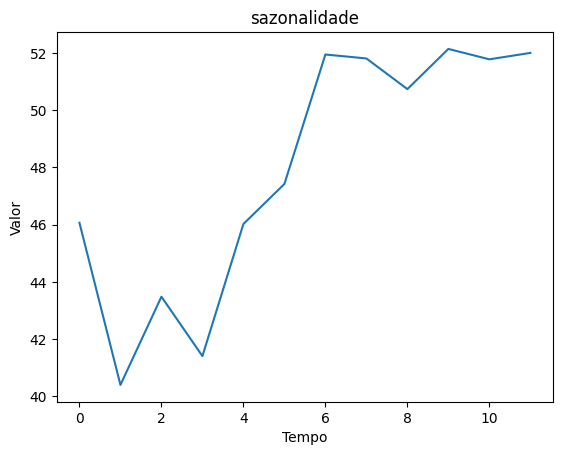

,sazonalidade
sazonalidade,
0,46.064857
1,40.394071
2,43.479464
3,41.402071
4,46.022714
5,47.422286
6,51.949714
7,51.811786
8,50.738929


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Piauí - IDH,Piauí - Produção de Cimento (t),Piauí - PIB - Estadual,Piauí - PIB - Construção Civil,Piauí - PIB - Per Capita,Piauí - PIB - Preços de Mercado,Piauí - Desemprego,sazonalidade,Piauí - Consumo de Cimento (t)
0,2003-1,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,0.649218,24.669760,2.136063e+07,1.358044e+06,6.061141,1.868149e+07,8.192266,46.064857,21.844
1,2003-2,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,0.649661,25.167145,2.139102e+07,1.359835e+06,6.065065,1.869506e+07,8.186156,40.394071,15.814
2,2003-3,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,0.650104,25.520404,2.142142e+07,1.361626e+06,6.068988,1.870864e+07,8.180046,43.479464,16.067
3,2003-4,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,0.650548,25.519725,2.145181e+07,1.363417e+06,6.072912,1.872222e+07,8.173937,41.402071,14.938
4,2003-5,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,0.650991,25.929312,2.148221e+07,1.365208e+06,6.076835,1.873580e+07,8.167827,46.022714,17.765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.957215,NaN,NaN,NaN,NaN,NaN,51.811786,77.776
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.965575,NaN,NaN,NaN,NaN,NaN,50.738929,72.377
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.977734,NaN,NaN,NaN,NaN,NaN,52.144929,71.791
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.994123,NaN,NaN,NaN,NaN,NaN,51.781071,71.015


In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      19.758
1      19.763
2      22.445
3      20.109
4      24.283
        ...  
235       NaN
236       NaN
237       NaN
238       NaN
239       NaN
Name: Piauí - Consumo de Cimento (t), Length: 240, dtype: float64

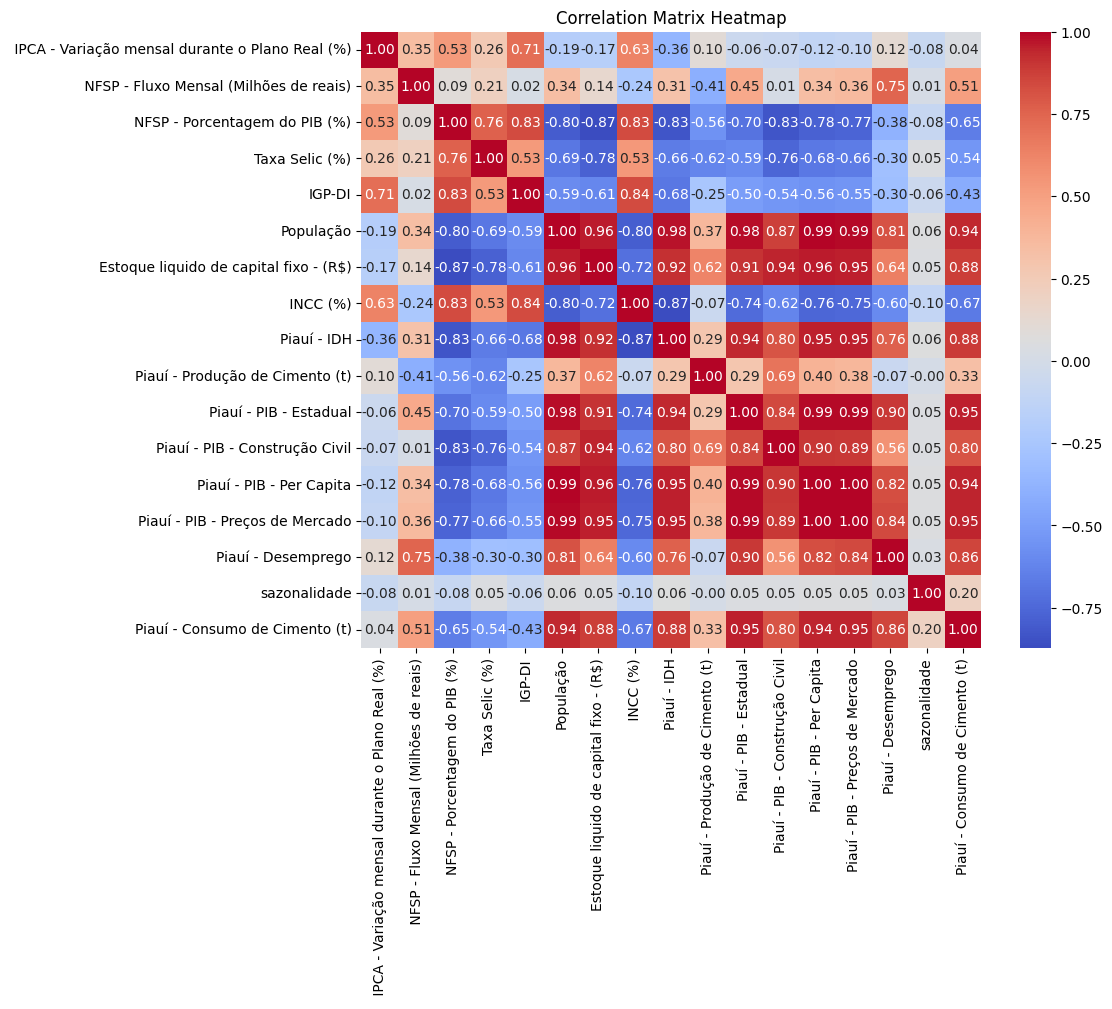

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,IPCA - Variação mensal durante o Plano Real (%),1.631194e+03
1,NFSP - Fluxo Mensal (Milhões de reais),1.692170e+02
2,NFSP - Porcentagem do PIB (%),4.774102e+02
3,Taxa Selic (%),5.746710e+01
4,IGP-DI,2.552105e+02
5,População,8.189644e+06
6,Estoque liquido de capital fixo - (R$),1.085503e+07
7,INCC (%),1.675992e+03
8,Piauí - IDH,1.068749e+06
9,Piauí - Produção de Cimento (t),6.259108e+03


In [39]:
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 2


,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Piauí - IDH,Piauí - Produção de Cimento (t),Piauí - PIB - Estadual,Piauí - PIB - Construção Civil,Piauí - Desemprego,sazonalidade
0,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,0.649218,24.669760,2.136063e+07,1.358044e+06,8.192266,46.064857
1,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,0.649661,25.167145,2.139102e+07,1.359835e+06,8.186156,40.394071
2,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,0.650104,25.520404,2.142142e+07,1.361626e+06,8.180046,43.479464
3,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,0.650548,25.519725,2.145181e+07,1.363417e+06,8.173937,41.402071
4,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,0.650991,25.929312,2.148221e+07,1.365208e+06,8.167827,46.022714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.366904,-5783.316460,2.206994,0.545067,0.471521,1.987710e+08,7.783063e+06,0.378150,0.689639,21.765063,2.657953e+07,1.434520e+06,11.093842,51.811786
176,0.358935,-6001.730740,2.215328,0.782910,0.476827,1.988450e+08,7.780841e+06,0.377666,0.689608,21.232248,2.657830e+07,1.434662e+06,11.082529,50.738929
177,0.354313,-6454.887704,2.232466,0.909682,0.475427,1.989190e+08,7.778619e+06,0.377838,0.689577,20.784566,2.657706e+07,1.434804e+06,11.071216,52.144929
178,0.352728,-6243.191421,2.263185,1.050614,0.491301,1.989930e+08,7.776397e+06,0.370057,0.689545,20.341515,2.657583e+07,1.434946e+06,11.059902,51.781071


In [40]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Piauí - IDH,Piauí - Produção de Cimento (t),Piauí - PIB - Estadual,Piauí - PIB - Construção Civil,Piauí - Desemprego
0,0.604311,4.268118,2.039314,3.921218,-2.016914,-2.299937,3.214079,-2.236341,-1.515936,-1.618874,-2.407469,-0.678784
1,0.609431,4.096014,1.195209,3.582946,-1.988421,-2.263992,3.051841,-2.194986,-1.463332,-1.601515,-2.341664,-0.683408
2,0.562720,3.903698,2.960381,3.422548,-1.959928,-2.228047,2.944772,-2.153631,-1.425971,-1.584156,-2.275858,-0.688031
3,0.455907,3.693727,1.040752,3.167136,-1.931435,-2.192102,2.842174,-2.112276,-1.426043,-1.566797,-2.210052,-0.692655
4,0.498418,3.454992,2.351150,2.986591,-1.902941,-2.156157,3.059587,-2.070921,-1.382725,-1.549438,-2.144247,-0.697279
...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.425789,-0.584804,-1.503380,-0.514871,1.368581,0.605679,-1.872446,1.534336,-1.823137,1.361835,0.402710,1.517122
176,0.339575,-0.580461,-0.733634,-0.473208,1.380202,0.591420,-1.876611,1.531410,-1.879487,1.361131,0.407931,1.508560
177,0.160702,-0.571531,-0.323353,-0.484199,1.391823,0.577161,-1.875135,1.528483,-1.926834,1.360427,0.413151,1.499999
178,0.244264,-0.555524,0.132757,-0.359568,1.403443,0.562902,-1.942040,1.525557,-1.973691,1.359723,0.418372,1.491437


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Piauí - IDH,Piauí - Produção de Cimento (t),Piauí - PIB - Estadual,Piauí - PIB - Construção Civil,Piauí - Desemprego
0,0.604311,4.268118,2.039314,3.921218,-2.016914,-2.299937,3.214079,-2.236341,-1.515936,-1.618874,-2.407469,-0.678784
1,0.609431,4.096014,1.195209,3.582946,-1.988421,-2.263992,3.051841,-2.194986,-1.463332,-1.601515,-2.341664,-0.683408
2,0.562720,3.903698,2.960381,3.422548,-1.959928,-2.228047,2.944772,-2.153631,-1.425971,-1.584156,-2.275858,-0.688031
3,0.455907,3.693727,1.040752,3.167136,-1.931435,-2.192102,2.842174,-2.112276,-1.426043,-1.566797,-2.210052,-0.692655
4,0.498418,3.454992,2.351150,2.986591,-1.902941,-2.156157,3.059587,-2.070921,-1.382725,-1.549438,-2.144247,-0.697279
...,...,...,...,...,...,...,...,...,...,...,...,...
163,1.465326,-0.676734,0.472779,-1.087000,1.228701,0.759879,-1.491033,1.539084,-0.869815,1.334620,0.364987,1.586760
164,1.351131,-0.668750,0.302784,-0.904679,1.240408,0.749001,-1.525186,1.542231,-0.955645,1.341049,0.365223,1.584819
165,1.143146,-0.657609,0.339539,-0.900134,1.252114,0.738124,-1.546744,1.545379,-1.042369,1.347478,0.365459,1.582878
166,1.542609,-0.647588,0.472795,-1.136836,1.263821,0.727246,-1.586381,1.548526,-1.130009,1.353907,0.365695,1.580938


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      19.758
1      19.763
2      22.445
3      20.109
4      24.283
        ...  
163    63.141
164    55.580
165    60.001
166    62.767
167    45.308
Name: Piauí - Consumo de Cimento (t), Length: 168, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 12)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Piauí - IDH,Piauí - Produção de Cimento (t),Piauí - PIB - Estadual,Piauí - PIB - Construção Civil,Piauí - Desemprego
132,0.817451,-0.366715,-0.530011,0.174628,0.848407,0.965586,-0.066954,0.494446,0.730865,1.016528,1.295893,1.074473
133,1.130195,-0.350285,-0.532694,0.240832,0.861179,0.962419,-0.130652,0.489582,0.691743,1.029004,1.248827,1.103260
134,1.160498,-0.335122,-0.186421,0.176857,0.873950,0.959252,-0.079602,0.484719,0.668829,1.041481,1.201761,1.132047
135,1.131990,-0.321950,-0.719664,-0.005233,0.886722,0.956085,-0.034473,0.479855,0.645546,1.053957,1.154696,1.160834
136,1.384387,-0.302995,-0.798520,0.097576,0.899493,0.952918,-0.177535,0.474991,0.622279,1.066434,1.107630,1.189622
137,1.375487,-0.290554,-0.612129,0.431487,0.912265,0.949751,-0.208868,0.470127,0.597882,1.078910,1.060564,1.218409
138,1.438928,-0.281926,-0.476740,0.482414,0.925036,0.946584,-0.245300,0.465263,0.573763,1.091387,1.013499,1.247196
139,1.569590,-0.275931,-0.211736,0.657043,0.937808,0.943417,-0.333490,0.460399,0.549317,1.103863,0.966433,1.275983
140,1.584058,-0.271466,-0.484608,0.678386,0.950580,0.940250,-0.296846,0.455535,0.525057,1.116340,0.919367,1.304770
141,1.166380,-0.273241,-0.183907,0.727143,0.963351,0.937082,-0.292462,0.450671,0.500879,1.128816,0.872302,1.333557


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 12)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(72, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(36, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.1,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, 
                              reshaped_target, 
                              reshaped_test, 
                              reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[1603416846, 2473135469, 2836913216, 2247237968, 763592845, 4009690309, 2956832189, 492954709, 3716390415, 1123337980]


Step: 0 ___________________________________________
val_loss: 251.3531951904297
winner_seed: 1603416846


Step: 1 ___________________________________________
val_loss: 241.27017211914062
winner_seed: 2473135469


Step: 2 ___________________________________________
val_loss: 383.1826477050781


Step: 3 ___________________________________________
val_loss: 229.8980255126953
winner_seed: 2247237968


Step: 4 ___________________________________________
val_loss: 412.8324890136719


Step: 5 ___________________________________________
val_loss: 292.4870300292969


Step: 6 ___________________________________________
val_loss: 362.94635009765625


Step: 7 ___________________________________________
val_loss: 341.5646667480469


Step: 8 ___________________________________________
val_loss: 301.0033874511719


Step: 9 ___________________________________________
val_loss: 342.3

In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 3430781553

Epoch 1/10000
4/4 [==============================] - 2s 116ms/step - loss: 3281.0759 - val_loss: 489.1441
Epoch 2/10000
4/4 [==============================] - 0s 7ms/step - loss: 699.8755 - val_loss: 102.3451
Epoch 3/10000
4/4 [==============================] - 0s 7ms/step - loss: 230.5119 - val_loss: 156.9731
Epoch 4/10000
4/4 [==============================] - 0s 7ms/step - loss: 168.4883 - val_loss: 214.1208
Epoch 5/10000
4/4 [==============================] - 0s 7ms/step - loss: 170.8992 - val_loss: 204.2108
Epoch 6/10000
4/4 [==============================] - 0s 7ms/step - loss: 105.7440 - val_loss: 311.0934
Epoch 7/10000
4/4 [==============================] - 0s 7ms/step - loss: 81.5344 - val_loss: 414.3892
Epoch 8/10000
4/4 [==============================] - 0s 7ms/step - loss: 108.0423 - val_loss: 424.9109
Epoch 9/10000
4/4 [==============================] - 0s 7ms/step - loss: 69.7291 - val_loss: 442.1609
Epoch 10/10000
4/4 [==============================] - 0s 7ms/step - loss

4/4 [==============================] - 0s 7ms/step - loss: 28.8144 - val_loss: 419.8736
Epoch 81/10000
4/4 [==============================] - 0s 7ms/step - loss: 34.6530 - val_loss: 374.1709
Epoch 82/10000
4/4 [==============================] - 0s 7ms/step - loss: 31.2638 - val_loss: 390.8103
Epoch 83/10000
4/4 [==============================] - 0s 7ms/step - loss: 28.1594 - val_loss: 414.6792
Epoch 84/10000
4/4 [==============================] - 0s 7ms/step - loss: 29.5582 - val_loss: 434.3811
Epoch 85/10000
4/4 [==============================] - 0s 7ms/step - loss: 33.2200 - val_loss: 392.6765
Epoch 86/10000
4/4 [==============================] - 0s 7ms/step - loss: 30.1021 - val_loss: 400.5067
Epoch 87/10000
4/4 [==============================] - 0s 7ms/step - loss: 33.2124 - val_loss: 401.8645
Epoch 88/10000
4/4 [==============================] - 0s 7ms/step - loss: 29.8529 - val_loss: 375.4193
Epoch 89/10000
4/4 [==============================] - 0s 7ms/step - loss: 34.5488 - val_

4/4 [==============================] - 0s 7ms/step - loss: 25.2756 - val_loss: 435.5500
Epoch 160/10000
4/4 [==============================] - 0s 7ms/step - loss: 25.5134 - val_loss: 433.6389
Epoch 161/10000
4/4 [==============================] - 0s 7ms/step - loss: 26.6533 - val_loss: 441.7803
Epoch 162/10000
4/4 [==============================] - 0s 7ms/step - loss: 27.6123 - val_loss: 385.9474
Epoch 163/10000
4/4 [==============================] - 0s 7ms/step - loss: 30.0943 - val_loss: 421.5574
Epoch 164/10000
4/4 [==============================] - 0s 7ms/step - loss: 27.7067 - val_loss: 375.3716
Epoch 165/10000
4/4 [==============================] - 0s 7ms/step - loss: 27.9297 - val_loss: 399.5043
Epoch 166/10000
4/4 [==============================] - 0s 7ms/step - loss: 26.5362 - val_loss: 427.2592
Epoch 167/10000
4/4 [==============================] - 0s 7ms/step - loss: 25.6086 - val_loss: 399.3933
Epoch 168/10000
4/4 [==============================] - 0s 7ms/step - loss: 25.29

Epoch 238/10000
4/4 [==============================] - 0s 7ms/step - loss: 19.7960 - val_loss: 417.6898
Epoch 239/10000
4/4 [==============================] - 0s 7ms/step - loss: 19.0968 - val_loss: 466.2419
Epoch 240/10000
4/4 [==============================] - 0s 8ms/step - loss: 19.6974 - val_loss: 448.3755
Epoch 241/10000
4/4 [==============================] - 0s 8ms/step - loss: 18.1541 - val_loss: 454.7007
Epoch 242/10000
4/4 [==============================] - 0s 7ms/step - loss: 17.9320 - val_loss: 466.4839
Epoch 243/10000
4/4 [==============================] - 0s 7ms/step - loss: 18.4782 - val_loss: 463.8398
Epoch 244/10000
4/4 [==============================] - 0s 7ms/step - loss: 16.9111 - val_loss: 436.6742
Epoch 245/10000
4/4 [==============================] - 0s 7ms/step - loss: 17.8308 - val_loss: 474.2040
Epoch 246/10000
4/4 [==============================] - 0s 7ms/step - loss: 22.7311 - val_loss: 446.9362
Epoch 247/10000
4/4 [==============================] - 0s 7ms/st

Epoch 317/10000
4/4 [==============================] - 0s 7ms/step - loss: 15.4792 - val_loss: 473.7274
Epoch 318/10000
4/4 [==============================] - 0s 7ms/step - loss: 15.0459 - val_loss: 482.0431
Epoch 319/10000
4/4 [==============================] - 0s 7ms/step - loss: 18.0062 - val_loss: 487.6600
Epoch 320/10000
4/4 [==============================] - 0s 7ms/step - loss: 14.9548 - val_loss: 483.2779
Epoch 321/10000
4/4 [==============================] - 0s 7ms/step - loss: 17.3785 - val_loss: 461.5617
Epoch 322/10000
4/4 [==============================] - 0s 7ms/step - loss: 15.7765 - val_loss: 475.7962
Epoch 323/10000
4/4 [==============================] - 0s 7ms/step - loss: 15.2583 - val_loss: 490.0343
Epoch 324/10000
4/4 [==============================] - 0s 7ms/step - loss: 18.4190 - val_loss: 471.9520
Epoch 325/10000
4/4 [==============================] - 0s 7ms/step - loss: 15.7781 - val_loss: 442.5370
Epoch 326/10000
4/4 [==============================] - 0s 7ms/st

Epoch 396/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.3615 - val_loss: 494.0335
Epoch 397/10000
4/4 [==============================] - 0s 7ms/step - loss: 14.0902 - val_loss: 496.7766
Epoch 398/10000
4/4 [==============================] - 0s 7ms/step - loss: 12.4078 - val_loss: 488.0518
Epoch 399/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.7513 - val_loss: 485.7581
Epoch 400/10000
4/4 [==============================] - 0s 7ms/step - loss: 16.4041 - val_loss: 474.5523
Epoch 401/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.0027 - val_loss: 492.1142
Epoch 402/10000
4/4 [==============================] - 0s 7ms/step - loss: 12.9723 - val_loss: 465.1626
Epoch 403/10000
4/4 [==============================] - 0s 7ms/step - loss: 14.0574 - val_loss: 502.4884
Epoch 404/10000
4/4 [==============================] - 0s 7ms/step - loss: 15.4403 - val_loss: 485.7583
Epoch 405/10000
4/4 [==============================] - 0s 7ms/st

Epoch 475/10000
4/4 [==============================] - 0s 7ms/step - loss: 11.8562 - val_loss: 478.8579
Epoch 476/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.4094 - val_loss: 508.5054
Epoch 477/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.4152 - val_loss: 515.2042
Epoch 478/10000
4/4 [==============================] - 0s 7ms/step - loss: 15.1101 - val_loss: 496.8687
Epoch 479/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.1915 - val_loss: 450.1997
Epoch 480/10000
4/4 [==============================] - 0s 7ms/step - loss: 14.7167 - val_loss: 497.0773
Epoch 481/10000
4/4 [==============================] - 0s 7ms/step - loss: 12.9382 - val_loss: 480.6213
Epoch 482/10000
4/4 [==============================] - 0s 7ms/step - loss: 9.4460 - val_loss: 475.9691
Epoch 483/10000
4/4 [==============================] - 0s 7ms/step - loss: 10.0498 - val_loss: 487.5117
Epoch 484/10000
4/4 [==============================] - 0s 7ms/ste

Epoch 554/10000
4/4 [==============================] - 0s 7ms/step - loss: 15.2029 - val_loss: 462.3782
Epoch 555/10000
4/4 [==============================] - 0s 7ms/step - loss: 11.7877 - val_loss: 472.3626
Epoch 556/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.1963 - val_loss: 469.6880
Epoch 557/10000
4/4 [==============================] - 0s 7ms/step - loss: 10.9581 - val_loss: 472.0155
Epoch 558/10000
4/4 [==============================] - 0s 7ms/step - loss: 10.3480 - val_loss: 467.3336
Epoch 559/10000
4/4 [==============================] - 0s 7ms/step - loss: 14.0551 - val_loss: 449.1371
Epoch 560/10000
4/4 [==============================] - 0s 7ms/step - loss: 13.5072 - val_loss: 480.5910
Epoch 561/10000
4/4 [==============================] - 0s 7ms/step - loss: 10.7803 - val_loss: 481.7924
Epoch 562/10000
4/4 [==============================] - 0s 7ms/step - loss: 12.6413 - val_loss: 468.6463
Epoch 563/10000
4/4 [==============================] - 0s 7ms/st

Epoch 633/10000
4/4 [==============================] - 0s 7ms/step - loss: 11.2905 - val_loss: 489.8636
Epoch 634/10000
4/4 [==============================] - 0s 7ms/step - loss: 10.1472 - val_loss: 494.8914
Epoch 635/10000
4/4 [==============================] - 0s 7ms/step - loss: 10.4255 - val_loss: 484.6687
Epoch 636/10000
4/4 [==============================] - 0s 7ms/step - loss: 10.5653 - val_loss: 469.8598
Epoch 637/10000
4/4 [==============================] - 0s 7ms/step - loss: 11.0401 - val_loss: 471.0401
Epoch 638/10000
4/4 [==============================] - 0s 7ms/step - loss: 11.4386 - val_loss: 484.2619
Epoch 639/10000
4/4 [==============================] - 0s 7ms/step - loss: 9.2724 - val_loss: 475.3347
Epoch 640/10000
4/4 [==============================] - 0s 7ms/step - loss: 10.4441 - val_loss: 471.0438
Epoch 641/10000
4/4 [==============================] - 0s 7ms/step - loss: 9.2081 - val_loss: 475.5323
Epoch 642/10000
4/4 [==============================] - 0s 7ms/step

Epoch 712/10000
4/4 [==============================] - 0s 7ms/step - loss: 11.1607 - val_loss: 449.5912
Epoch 713/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.9014 - val_loss: 453.7310
Epoch 714/10000
4/4 [==============================] - 0s 7ms/step - loss: 9.9227 - val_loss: 442.2805
Epoch 715/10000
4/4 [==============================] - 0s 7ms/step - loss: 10.0424 - val_loss: 467.0648
Epoch 716/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.8892 - val_loss: 455.1816
Epoch 717/10000
4/4 [==============================] - 0s 7ms/step - loss: 10.2866 - val_loss: 466.9302
Epoch 718/10000
4/4 [==============================] - 0s 7ms/step - loss: 10.0489 - val_loss: 463.9396
Epoch 719/10000
4/4 [==============================] - 0s 7ms/step - loss: 10.1277 - val_loss: 467.4777
Epoch 720/10000
4/4 [==============================] - 0s 7ms/step - loss: 11.4304 - val_loss: 470.6651
Epoch 721/10000
4/4 [==============================] - 0s 7ms/step 

4/4 [==============================] - 0s 7ms/step - loss: 9.7166 - val_loss: 486.2876
Epoch 792/10000
4/4 [==============================] - 0s 7ms/step - loss: 9.5086 - val_loss: 443.2873
Epoch 793/10000
4/4 [==============================] - 0s 7ms/step - loss: 12.7019 - val_loss: 470.5591
Epoch 794/10000
4/4 [==============================] - 0s 7ms/step - loss: 11.8644 - val_loss: 468.8047
Epoch 795/10000
4/4 [==============================] - 0s 7ms/step - loss: 9.5749 - val_loss: 475.4463
Epoch 796/10000
4/4 [==============================] - 0s 7ms/step - loss: 10.0956 - val_loss: 484.1588
Epoch 797/10000
4/4 [==============================] - 0s 7ms/step - loss: 10.9583 - val_loss: 476.6323
Epoch 798/10000
4/4 [==============================] - 0s 7ms/step - loss: 9.8911 - val_loss: 482.6657
Epoch 799/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.7079 - val_loss: 475.4902
Epoch 800/10000
4/4 [==============================] - 0s 7ms/step - loss: 9.2018 - v

4/4 [==============================] - 0s 7ms/step - loss: 10.3236 - val_loss: 477.8816
Epoch 871/10000
4/4 [==============================] - 0s 7ms/step - loss: 10.8577 - val_loss: 470.9263
Epoch 872/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.9694 - val_loss: 470.5198
Epoch 873/10000
4/4 [==============================] - 0s 7ms/step - loss: 9.5586 - val_loss: 479.7605
Epoch 874/10000
4/4 [==============================] - 0s 7ms/step - loss: 9.0759 - val_loss: 444.1401
Epoch 875/10000
4/4 [==============================] - 0s 7ms/step - loss: 9.6103 - val_loss: 470.0859
Epoch 876/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.6992 - val_loss: 459.6598
Epoch 877/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.5253 - val_loss: 476.2922
Epoch 878/10000
4/4 [==============================] - 0s 7ms/step - loss: 9.9662 - val_loss: 454.6775
Epoch 879/10000
4/4 [==============================] - 0s 7ms/step - loss: 9.3001 - val

4/4 [==============================] - 0s 7ms/step - loss: 8.4380 - val_loss: 456.7183
Epoch 950/10000
4/4 [==============================] - 0s 7ms/step - loss: 9.2468 - val_loss: 451.5830
Epoch 951/10000
4/4 [==============================] - 0s 7ms/step - loss: 9.8640 - val_loss: 460.2455
Epoch 952/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.6830 - val_loss: 451.0627
Epoch 953/10000
4/4 [==============================] - 0s 7ms/step - loss: 10.0462 - val_loss: 463.7590
Epoch 954/10000
4/4 [==============================] - 0s 7ms/step - loss: 9.5904 - val_loss: 459.0764
Epoch 955/10000
4/4 [==============================] - 0s 7ms/step - loss: 10.2544 - val_loss: 460.9735
Epoch 956/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.3864 - val_loss: 468.1772
Epoch 957/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.8989 - val_loss: 470.4406
Epoch 958/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.9583 - val

4/4 [==============================] - 0s 7ms/step - loss: 9.5729 - val_loss: 474.6891
Epoch 1029/10000
4/4 [==============================] - 0s 7ms/step - loss: 9.2724 - val_loss: 417.1445
Epoch 1030/10000
4/4 [==============================] - 0s 7ms/step - loss: 10.7337 - val_loss: 430.6803
Epoch 1031/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.3621 - val_loss: 448.3592
Epoch 1032/10000
4/4 [==============================] - 0s 7ms/step - loss: 9.3942 - val_loss: 453.7859
Epoch 1033/10000
4/4 [==============================] - 0s 7ms/step - loss: 9.4028 - val_loss: 441.3844
Epoch 1034/10000
4/4 [==============================] - 0s 7ms/step - loss: 9.9388 - val_loss: 434.7667
Epoch 1035/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.5063 - val_loss: 455.5903
Epoch 1036/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.5467 - val_loss: 447.2063
Epoch 1037/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.75

Epoch 1107/10000
4/4 [==============================] - 0s 7ms/step - loss: 9.3733 - val_loss: 445.1383
Epoch 1108/10000
4/4 [==============================] - 0s 7ms/step - loss: 10.9867 - val_loss: 427.7183
Epoch 1109/10000
4/4 [==============================] - 0s 7ms/step - loss: 14.5603 - val_loss: 403.3166
Epoch 1110/10000
4/4 [==============================] - 0s 8ms/step - loss: 13.1165 - val_loss: 381.4362
Epoch 1111/10000
4/4 [==============================] - 0s 7ms/step - loss: 12.5303 - val_loss: 405.7884
Epoch 1112/10000
4/4 [==============================] - 0s 7ms/step - loss: 10.7521 - val_loss: 410.2489
Epoch 1113/10000
4/4 [==============================] - 0s 8ms/step - loss: 12.7074 - val_loss: 377.7856
Epoch 1114/10000
4/4 [==============================] - 0s 7ms/step - loss: 10.8056 - val_loss: 419.9577
Epoch 1115/10000
4/4 [==============================] - 0s 7ms/step - loss: 11.1270 - val_loss: 432.4157
Epoch 1116/10000
4/4 [==============================] - 

4/4 [==============================] - 0s 7ms/step - loss: 9.2517 - val_loss: 447.7803
Epoch 1186/10000
4/4 [==============================] - 0s 7ms/step - loss: 9.1691 - val_loss: 439.9018
Epoch 1187/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.6312 - val_loss: 438.1930
Epoch 1188/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.2073 - val_loss: 409.0373
Epoch 1189/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.7252 - val_loss: 441.3753
Epoch 1190/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.0750 - val_loss: 428.3235
Epoch 1191/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.3303 - val_loss: 433.0522
Epoch 1192/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.2552 - val_loss: 416.3210
Epoch 1193/10000
4/4 [==============================] - 0s 7ms/step - loss: 10.1941 - val_loss: 426.2831
Epoch 1194/10000
4/4 [==============================] - 0s 7ms/step - loss: 11.3

Epoch 1264/10000
4/4 [==============================] - 0s 7ms/step - loss: 9.0241 - val_loss: 398.3648
Epoch 1265/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.5263 - val_loss: 413.0047
Epoch 1266/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.9091 - val_loss: 422.1978
Epoch 1267/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.9687 - val_loss: 420.2326
Epoch 1268/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.1124 - val_loss: 428.3156
Epoch 1269/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.5695 - val_loss: 448.2957
Epoch 1270/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.9581 - val_loss: 446.6226
Epoch 1271/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.1425 - val_loss: 424.4471
Epoch 1272/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.7219 - val_loss: 438.5862
Epoch 1273/10000
4/4 [==============================] - 0s 7ms/s

Epoch 1343/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.6308 - val_loss: 399.5847
Epoch 1344/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.4037 - val_loss: 408.3127
Epoch 1345/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.0993 - val_loss: 396.1791
Epoch 1346/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.5039 - val_loss: 417.4361
Epoch 1347/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.4405 - val_loss: 409.2666
Epoch 1348/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.5721 - val_loss: 406.7849
Epoch 1349/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.0622 - val_loss: 420.0936
Epoch 1350/10000
4/4 [==============================] - 0s 7ms/step - loss: 10.3606 - val_loss: 385.6546
Epoch 1351/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.3862 - val_loss: 398.7380
Epoch 1352/10000
4/4 [==============================] - 0s 7ms/

4/4 [==============================] - 0s 7ms/step - loss: 7.6519 - val_loss: 395.5966
Epoch 1422/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.3064 - val_loss: 400.4844
Epoch 1423/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.7075 - val_loss: 398.7782
Epoch 1424/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.3802 - val_loss: 387.5897
Epoch 1425/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.3789 - val_loss: 385.4753
Epoch 1426/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.9838 - val_loss: 402.0295
Epoch 1427/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.4416 - val_loss: 376.6283
Epoch 1428/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.2268 - val_loss: 381.2162
Epoch 1429/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.3246 - val_loss: 397.1831
Epoch 1430/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.575

Epoch 1500/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.4479 - val_loss: 388.4318
Epoch 1501/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.7310 - val_loss: 367.6974
Epoch 1502/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.2675 - val_loss: 378.1884
Epoch 1503/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.2353 - val_loss: 380.1108
Epoch 1504/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.7260 - val_loss: 390.0752
Epoch 1505/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.4053 - val_loss: 370.6878
Epoch 1506/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.1774 - val_loss: 362.5749
Epoch 1507/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.6051 - val_loss: 363.6032
Epoch 1508/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.1625 - val_loss: 378.1365
Epoch 1509/10000
4/4 [==============================] - 0s 7ms/s

4/4 [==============================] - 0s 7ms/step - loss: 9.3935 - val_loss: 374.6295
Epoch 1579/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.8089 - val_loss: 391.2309
Epoch 1580/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.7849 - val_loss: 372.6357
Epoch 1581/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.4900 - val_loss: 411.6935
Epoch 1582/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.4942 - val_loss: 376.1452
Epoch 1583/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.8082 - val_loss: 391.8749
Epoch 1584/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.6791 - val_loss: 380.7336
Epoch 1585/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.4881 - val_loss: 387.1201
Epoch 1586/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.1071 - val_loss: 389.6829
Epoch 1587/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.594

Epoch 1657/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.3963 - val_loss: 315.2722
Epoch 1658/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.3741 - val_loss: 340.8875
Epoch 1659/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.5276 - val_loss: 323.9617
Epoch 1660/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.1535 - val_loss: 320.7420
Epoch 1661/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.6638 - val_loss: 328.2685
Epoch 1662/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.7979 - val_loss: 315.1298
Epoch 1663/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.1318 - val_loss: 305.9499
Epoch 1664/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.7715 - val_loss: 328.0378
Epoch 1665/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.4788 - val_loss: 322.2198
Epoch 1666/10000
4/4 [==============================] - 0s 7ms/s

Epoch 1736/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.0215 - val_loss: 306.5814
Epoch 1737/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.6077 - val_loss: 304.0451
Epoch 1738/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.4581 - val_loss: 283.4127
Epoch 1739/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.6262 - val_loss: 309.4392
Epoch 1740/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.2164 - val_loss: 306.6057
Epoch 1741/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.7443 - val_loss: 299.5210
Epoch 1742/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.8864 - val_loss: 305.3091
Epoch 1743/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.6442 - val_loss: 307.7946
Epoch 1744/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.8392 - val_loss: 304.7138
Epoch 1745/10000
4/4 [==============================] - 0s 7ms/s

Epoch 1815/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.4016 - val_loss: 287.5579
Epoch 1816/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.5943 - val_loss: 276.9770
Epoch 1817/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.0573 - val_loss: 291.7916
Epoch 1818/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.9078 - val_loss: 294.8299
Epoch 1819/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.9088 - val_loss: 276.0095
Epoch 1820/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.7855 - val_loss: 287.1592
Epoch 1821/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.6320 - val_loss: 297.8152
Epoch 1822/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.8214 - val_loss: 291.1784
Epoch 1823/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.5253 - val_loss: 282.3495
Epoch 1824/10000
4/4 [==============================] - 0s 7ms/s

Epoch 1894/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.0492 - val_loss: 284.3976
Epoch 1895/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.5230 - val_loss: 271.8145
Epoch 1896/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.2996 - val_loss: 275.4423
Epoch 1897/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.3657 - val_loss: 258.1583
Epoch 1898/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.2921 - val_loss: 288.5374
Epoch 1899/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.4678 - val_loss: 285.6624
Epoch 1900/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.1944 - val_loss: 270.8891
Epoch 1901/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.8330 - val_loss: 272.5485
Epoch 1902/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.4083 - val_loss: 269.0462
Epoch 1903/10000
4/4 [==============================] - 0s 7ms/s

Epoch 1973/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.8916 - val_loss: 271.5211
Epoch 1974/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.9934 - val_loss: 268.2625
Epoch 1975/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.4944 - val_loss: 275.2824
Epoch 1976/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.3130 - val_loss: 270.0592
Epoch 1977/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.3682 - val_loss: 285.8831
Epoch 1978/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.8216 - val_loss: 271.0641
Epoch 1979/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.9198 - val_loss: 268.7417
Epoch 1980/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.9299 - val_loss: 269.4857
Epoch 1981/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.4916 - val_loss: 296.1219
Epoch 1982/10000
4/4 [==============================] - 0s 7ms/s

Epoch 2052/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.3328 - val_loss: 266.0047
Epoch 2053/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.7825 - val_loss: 271.4087
Epoch 2054/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.2344 - val_loss: 274.1936
Epoch 2055/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.7340 - val_loss: 257.5025
Epoch 2056/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.4105 - val_loss: 269.1198
Epoch 2057/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.8589 - val_loss: 257.1697
Epoch 2058/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.1350 - val_loss: 276.2928
Epoch 2059/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.6191 - val_loss: 272.3244
Epoch 2060/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.4818 - val_loss: 259.4939
Epoch 2061/10000
4/4 [==============================] - 0s 7ms/s

Epoch 2131/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.2863 - val_loss: 255.6450
Epoch 2132/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.7563 - val_loss: 271.4554
Epoch 2133/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.7154 - val_loss: 275.8047
Epoch 2134/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.1539 - val_loss: 258.3037
Epoch 2135/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.9164 - val_loss: 265.7163
Epoch 2136/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.8935 - val_loss: 281.2727
Epoch 2137/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.8767 - val_loss: 275.0618
Epoch 2138/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.2129 - val_loss: 309.1721
Epoch 2139/10000
4/4 [==============================] - 0s 7ms/step - loss: 9.0674 - val_loss: 284.1078
Epoch 2140/10000
4/4 [==============================] - 0s 7ms/s

Epoch 2210/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.7719 - val_loss: 253.2255
Epoch 2211/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.5883 - val_loss: 261.0829
Epoch 2212/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.5121 - val_loss: 267.1801
Epoch 2213/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.9187 - val_loss: 255.1550
Epoch 2214/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.4304 - val_loss: 267.9277
Epoch 2215/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.6301 - val_loss: 265.4880
Epoch 2216/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.9624 - val_loss: 270.3423
Epoch 2217/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.2042 - val_loss: 263.1316
Epoch 2218/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.9016 - val_loss: 258.8098
Epoch 2219/10000
4/4 [==============================] - 0s 7ms/s

Epoch 2289/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.2761 - val_loss: 260.4044
Epoch 2290/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.5353 - val_loss: 247.6419
Epoch 2291/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.8503 - val_loss: 244.1623
Epoch 2292/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.0408 - val_loss: 248.0518
Epoch 2293/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.4041 - val_loss: 250.8787
Epoch 2294/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.7765 - val_loss: 239.8506
Epoch 2295/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.1162 - val_loss: 259.6977
Epoch 2296/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.2445 - val_loss: 248.7169
Epoch 2297/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.4944 - val_loss: 233.1900
Epoch 2298/10000
4/4 [==============================] - 0s 7ms/s

Epoch 2368/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.0584 - val_loss: 263.4523
Epoch 2369/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.4982 - val_loss: 250.6515
Epoch 2370/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.7653 - val_loss: 243.2784
Epoch 2371/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.1461 - val_loss: 236.0008
Epoch 2372/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.5421 - val_loss: 233.9211
Epoch 2373/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.5424 - val_loss: 246.0569
Epoch 2374/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.6009 - val_loss: 246.2849
Epoch 2375/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.8737 - val_loss: 251.2744
Epoch 2376/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.5741 - val_loss: 242.6829
Epoch 2377/10000
4/4 [==============================] - 0s 7ms/s

Epoch 2447/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.8356 - val_loss: 279.5751
Epoch 2448/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.7249 - val_loss: 252.2626
Epoch 2449/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.5622 - val_loss: 266.4642
Epoch 2450/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.6613 - val_loss: 263.1752
Epoch 2451/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.2457 - val_loss: 274.4768
Epoch 2452/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.8675 - val_loss: 278.6529
Epoch 2453/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.7421 - val_loss: 283.6890
Epoch 2454/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.7065 - val_loss: 280.1132
Epoch 2455/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.0756 - val_loss: 270.4829
Epoch 2456/10000
4/4 [==============================] - 0s 7ms/s

Epoch 2526/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.1879 - val_loss: 261.4713
Epoch 2527/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.0868 - val_loss: 257.6182
Epoch 2528/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.3114 - val_loss: 253.7016
Epoch 2529/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.9389 - val_loss: 253.9067
Epoch 2530/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.1959 - val_loss: 259.1449
Epoch 2531/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.4097 - val_loss: 276.5551
Epoch 2532/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.2725 - val_loss: 280.7386
Epoch 2533/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.3436 - val_loss: 247.5890
Epoch 2534/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.7634 - val_loss: 264.4738
Epoch 2535/10000
4/4 [==============================] - 0s 7ms/s

4/4 [==============================] - 0s 7ms/step - loss: 5.0416 - val_loss: 318.8931
Epoch 2605/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.0021 - val_loss: 304.4896
Epoch 2606/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.4179 - val_loss: 288.4255
Epoch 2607/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.3566 - val_loss: 286.3962
Epoch 2608/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.2411 - val_loss: 303.4328
Epoch 2609/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.1249 - val_loss: 252.2857
Epoch 2610/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.7247 - val_loss: 320.3153
Epoch 2611/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.3113 - val_loss: 327.2296
Epoch 2612/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.0017 - val_loss: 307.4610
Epoch 2613/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.990

Epoch 2683/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.1457 - val_loss: 292.4424
Epoch 2684/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.6013 - val_loss: 333.2159
Epoch 2685/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.0790 - val_loss: 299.7498
Epoch 2686/10000
4/4 [==============================] - 0s 7ms/step - loss: 9.3761 - val_loss: 281.6320
Epoch 2687/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.6801 - val_loss: 328.0516
Epoch 2688/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.5108 - val_loss: 317.3417
Epoch 2689/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.5343 - val_loss: 286.2075
Epoch 2690/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.9495 - val_loss: 309.5578
Epoch 2691/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.5998 - val_loss: 292.4642
Epoch 2692/10000
4/4 [==============================] - 0s 8ms/s

Epoch 2762/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.7706 - val_loss: 312.0440
Epoch 2763/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.7477 - val_loss: 301.1043
Epoch 2764/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.5469 - val_loss: 313.5249
Epoch 2765/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.0450 - val_loss: 306.6862
Epoch 2766/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.8603 - val_loss: 310.3787
Epoch 2767/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.2823 - val_loss: 300.4656
Epoch 2768/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.8031 - val_loss: 279.3743
Epoch 2769/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.0371 - val_loss: 297.1035
Epoch 2770/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.4682 - val_loss: 307.0490
Epoch 2771/10000
4/4 [==============================] - 0s 8ms/s

Epoch 2841/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.1474 - val_loss: 325.1523
Epoch 2842/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.2590 - val_loss: 314.6884
Epoch 2843/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.1804 - val_loss: 312.0698
Epoch 2844/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.1782 - val_loss: 340.0368
Epoch 2845/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.2928 - val_loss: 332.6751
Epoch 2846/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.1710 - val_loss: 302.6115
Epoch 2847/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.2626 - val_loss: 319.0898
Epoch 2848/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.1321 - val_loss: 328.1371
Epoch 2849/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.9411 - val_loss: 314.7102
Epoch 2850/10000
4/4 [==============================] - 0s 8ms/s

In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 13ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,64.13192,63.808678,64.176888,64.425407,64.518265,64.399445,63.786072,63.308067,63.259331,62.694878,62.119968,60.816544
Target,57.142,46.283,43.39,40.824,55.063,56.474,68.133,68.642,64.741,71.269,67.631,62.845
Error,6.989922,17.525677,20.786888,23.601406,9.455265,7.925446,4.346931,5.333931,1.481667,8.57412,5.511028,2.028458


In [54]:
display(mae)
display(mape)

9.463395

0.18905868

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model,
                                             reshaped_test, 
                                             reshaped_test_target,
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 13ms/step
Ano-11: |Prediction[[761.4455]] - Target[702.437]| =  Error: [[59.008484]]; MAPE:[[0.08400537]]


[array([[59.008484]], dtype=float32)]

59.008484

0.08400537